<div class="span5 alert alert-info">
<p>I obtained data for this project from the Children of Immigrants Longitudinal Study (CILS). The first survey was conducted in 1992 when the respondents were either in 8th or 9th grade. A follow-up survey was conducted when the respondents were about to graduate highschool. The investigators sought to "examine the evolution of key adaptation outcomes including language knowledge and preference, ethnic identity, self-esteem, and academic attainment over the adolescent years." The dataset also includes a survey of one of the child's parents. I employ these factors to predict college completion of the children in the survey.
    
Link: https://www.icpsr.umich.edu/icpsrweb/DSDR/studies/20520 </p>
</div>



In [141]:
#Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [143]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix 
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [144]:
from IPython.display import display

In [145]:
# read datafile
raw_df = pd.read_csv('C:/Users/airshu23/Desktop/Capstone2/ICPSR_20520/DS0001/Data.tsv', sep='\t')

C:\Users\airshu23\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,16,17,19,20,22,23,24,25,26,52,68,102,108,116,118,120,122,124,130,136,137,138,523,525,543,546,612,664) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [146]:
# Establish index to CASEID
raw_df.set_index('CASEID', inplace = True)

## Data Wrangling

In [147]:
# copy into new dataframe for modification
df = raw_df.copy()

# convert all entries to string so that the function in the next cell runs properly
df = df[df.columns].astype(str)

In [148]:
#check for alphabet in column values
def check(series):
    
    if series.str.contains('[a-z]', regex = True).sum() > 0:
        return True
    return False


In [152]:
dropped = [var for var in list(df.columns) if check(df[var]) == True]

# remove variables with alphabet characters
df.drop(dropped, inplace = True, axis=1)

# convert entries to numeric
df = df[df.columns].apply(pd.to_numeric, errors='coerce')

df.head(5)

,V1,V2,V4,V5,V7,V8,V9,V10,V11,V13,...,V448G,V448H,V448I,V448J,V448K,V448L,V448M,V448N,V449,V450
CASEID,,,,,,,,,,,,,,,,,,,,,
1,257,1,7,8,1.0,NaN,44.0,85.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,13.0
2,2347,1,13,9,1.0,NaN,102.0,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0
3,860,1,12,9,2.0,1.0,78.0,69.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
4,5178,3,20,9,1.0,NaN,82.0,78.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0
5,1984,1,12,9,1.0,NaN,101.0,78.0,2.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0


In [92]:
#non-continuous, non-ordinal variables to remove
non_numerical = ['V204', 'V278A', 'P140', 'V37', 'V263', 'V1', 'V32', 'V233', 'V62']

#percentiles of Stanford Achievement test scores. dataset has actual score
redundant = ['V132', 'V134' ]

# remove variables with alphabet characters
df.drop(non_numerical + redundant, inplace = True, axis=1)

### Exploratory Data Analysis

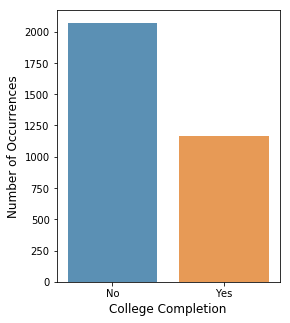

In [93]:
#College Completion

college_count  = df['V448M'].value_counts()
college_count.index = ['No', 'Yes']

plt.figure(figsize=(4,5))
sns.barplot(college_count.index, college_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('College Completion', fontsize=12)
plt.show()

In [94]:
#helper functions to convert values
def convert(value):
    if value == 1:
        return 'Yes'
    elif value == 0:
        return 'No'

def levels(value):
    if value == 1:
        return "Less than high school"
    elif value == 2:
        return "Finish high school"
    elif value == 3:
        return "Finish some college"
    elif value == 4:
        return "Finish college"
    elif value == 5:
        return "Finish a graduate degree"

In [95]:
# plot counts of college completion grouped by student's expectation
test = df.loc[: , ["V261","V448M"]]
test["Student's Expectation"] = test["V261"].apply(levels)
test["College Completion"] = test["V448M"].apply(convert)

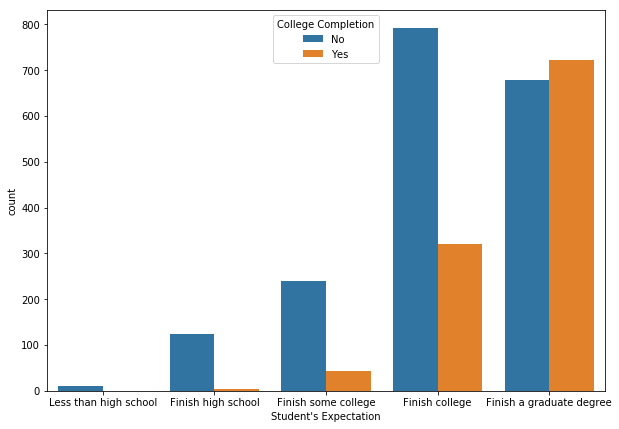

In [96]:
plt.figure(figsize=(10,7))
sns.countplot(x="Student's Expectation", hue="College Completion", order=["Less than high school", "Finish high school",
              "Finish some college", "Finish college", "Finish a graduate degree"], data=test)

plt.show()

Text(0, 0.5, "Student's Expectation")

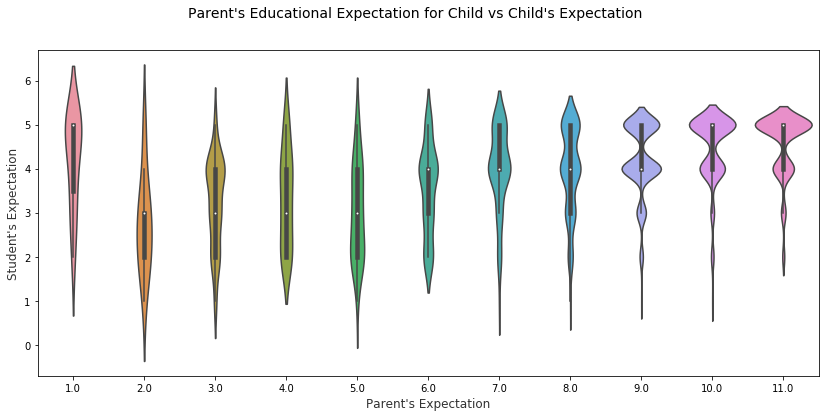

In [97]:
# Violon Plot
f, (ax) = plt.subplots(1, 1, figsize=(14, 6))
f.suptitle("Parent's Educational Expectation for Child vs Child's Expectation", fontsize=14)

sns.violinplot(x="P132", y="V261", data=df,  ax=ax)
ax.set_xlabel("Parent's Expectation",size = 12,alpha=0.8)
ax.set_ylabel("Student's Expectation",size = 12,alpha=0.8)

Text(0, 0.5, 'Self-Esteem Index in Highschool')

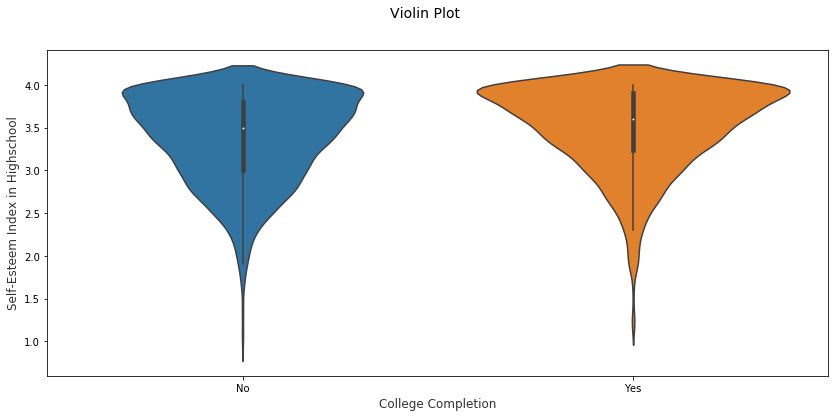

In [170]:
# Violon Plot
g, (ax2) = plt.subplots(1, 1, figsize=(14, 6))
g.suptitle("Violin Plot", fontsize=14)

sns.violinplot(x="V448M", y= "C17", data=df,  ax=ax2)
ax2.set_xlabel("College Completion",size = 12,alpha=0.8)
ax2.set_xticklabels(('No', 'Yes'))
ax2.set_ylabel("Self-Esteem Index in Highschool",size = 12,alpha=0.8)

Text(0, 0.5, "Father's Socio-economic Index Score")

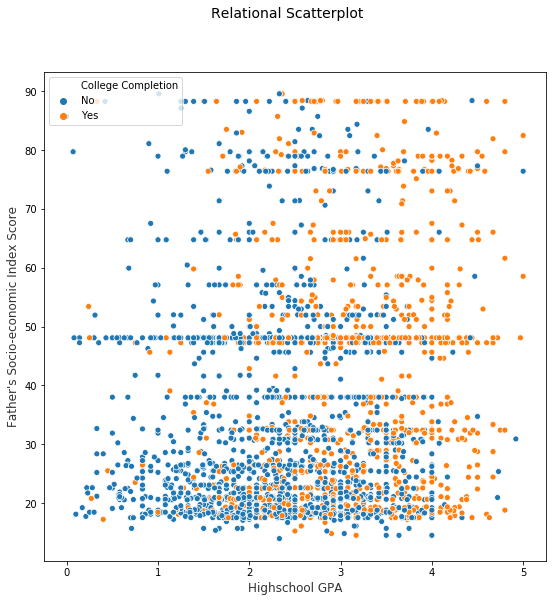

In [183]:
#Scatterplot
test3 = df.loc[: , ["V332","V123","V448M" ]]
test3["College Completion"] = test3["V448M"].apply(convert)

h, (ax3) = plt.subplots(1, 1, figsize=(9, 9))
h.suptitle("Relational Scatterplot", fontsize=14)

sns.scatterplot(x="V332", y="V123", hue="College Completion" , data=test3,  ax=ax3)

ax3.set_xlabel("Highschool GPA" ,size = 12,alpha=0.8)
ax3.set_ylabel("Father's Socio-economic Index Score" ,size = 12, alpha=0.8)



### Pre-processing

<div class="span5 alert alert-info">
<p>I am dropping all variables from the last follow-up survey except college completion. These variables maybe correlated with college completion status but are measured after college attendance. </p>
</div>


In [99]:
features = list(df.columns)

# get index of first year 2005 follow-up variable
first_2005 = features.index('V400')

# get index of last year 2005 follow-up variable
last_2005 = features.index('V450')

#all variables from (year) 2005 followup
variables_2005 = set(features[first_2005:last_2005+1])

#target variable to keep
keep_2005 = set(['V448M'])

# remove all year 2005 variables except V448M
drop_2005 = list(variables_2005.difference(keep_2005))

#drop from column headers above
df1 = df.drop(drop_2005, axis=1)


In [100]:
print (df1.shape)

(5262, 529)


<div class="span5 alert alert-info">
<p>Dropping observations that do not have survey of the parent. Also, excluding observations that do not have a college
completion indicator.</p>
</div>

In [101]:
# remove rows that do not have target variable - college completion
df1 = df1[pd.notnull(df1['V448M'])]

# remove rows that do not have parental survey completed
df1 = df1[pd.notnull(df1['P2A'])]

print (df1.shape)

(1703, 529)


<div class="span5 alert alert-info">
<p>Drop highly correlated features.</p>
</div>


In [102]:
# Create correlation matrix
corr_matrix = df1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df1 = df1.drop(to_drop, axis=1)

<div class="span5 alert alert-info">
<p> Removing columns that have less than 25% of the column entries filled with missing values . </p>
</div>

In [103]:
# missing values
test1 = df1.isnull().sum() / len(df1)

#all columns where number of missing values exceed 25%
testing = test1[test1>=0.25]

#columns in original df that have below 75% of values that is n/a 
below75 = list(testing.index.values)

#drop from column headers above
df2 = df1.drop(below75, axis=1)

print (df2.shape)


(1703, 401)


In [104]:
# imputing values for missing entries
df3 = df2.fillna(df2.median())

In [105]:
# Create a set of dummy variables from categorical variables
df3 = pd.get_dummies(df3, columns=['V2', 'V90','P14', 'P142'], drop_first = True)

In [106]:
#Convert original values
df3['V324E'] = np.where(df3['V324E']== 1.0, 1.0, 0.0)

#Stuff for P62D
df3['P62D'] = np.where(df3['P62D']== 1.0, 1.0, 0.0)

In [107]:
df3.isnull().values.any()

False

# Implementing Models

In [108]:
# split into feature and target variable

X = df3.drop('V448M', axis = 1)
y = df3['V448M']

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

In [109]:
# Create standardizer
standardizer = StandardScaler()

# Fit standardizer to training set 
standardizer.fit(X_train)

# Apply to both training and test sets to be used in Random Forest Model
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

C:\Users\airshu23\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\airshu23\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\airshu23\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


## Feature Selection using Recursive Feature Elimination

<div class="span5 alert alert-info">
<p>Choosing 20 variables that produce the best results. Logistic regression is as used as input inside recursive feature elimination function.</p>
</div>   

In [110]:
logit = LogisticRegression(solver='liblinear') ## chose high c-value to match results from statsmodels logistic regression
rfe = RFE(logit, 20)
rfe = rfe.fit(X_train, y_train)

In [111]:
# get indices of columns chosen in step above
col_indices = rfe.get_support(indices=True).tolist()

#Select only the top 20 variables from orignial dataframe
X_train_reduced = X_train.iloc[:, col_indices]
X_test_reduced = X_test.iloc[:, col_indices]

## Logistic Model 

In [112]:
# logistic model with constant term

X_const = sm.add_constant(X_train_reduced)
logit_model= sm.Logit(y_train, X_const)
result=logit_model.fit()

C:\Users\airshu23\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.507659
         Iterations 6


In [113]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  V448M   No. Observations:                 1362
Model:                          Logit   Df Residuals:                     1341
Method:                           MLE   Df Model:                           20
Date:                Sun, 07 Apr 2019   Pseudo R-squ.:                  0.2349
Time:                        20:40:07   Log-Likelihood:                -691.43
converged:                       True   LL-Null:                       -903.69
                                        LLR p-value:                 1.655e-77
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8534      1.168     -1.587      0.113      -4.142       0.436
V25           -1.0846      0.337     -3.215      0.001      -1.746      -0.423
V70            0.0842      0.183      0.460      0.645      -0.274       0.442
V74F           0.5062      0.248      2.039      0.041       0.020       0.993
V148           0.5239      0.095      5.506      0.000       0.337       0.710
V274C         -0.4061      0.100     -4.043      0.000      -0.603      -0.209
V324E         -0.6802      0.272     -2.497      0.013      -1.214      -0.146
V324F         -0.2434      0.399     -0.609      0.542      -1.026       0.540
V332           1.0375      0.094     11.016      0.000       0.853       1.222
V337          -0.8667      0.409     -2.118      0.034      -1.669      -0.065
P62D           0.4153      0.317      1.310      0.190      -0.206       1.037
P92D          -0.6326      0.373     -1.695      0.090      -1.364       0.099
P131          -0.3431      0.113     -3.028      0.002      -0.565      -0.121
C4             1.4307      0.350      4.088      0.000       0.745       2.117
V2_4          -0.9937      0.156     -6.376      0.000      -1.299      -0.688
V90_2.0       -0.5612      0.394     -1.424      0.154      -1.333       0.211
V90_3.0       -0.6588      0.526     -1.251      0.211      -1.691       0.373
P14_2.0       -0.5701      0.259     -2.201      0.028      -1.078      -0.063
P14_3.0       -1.8734      0.925     -2.024      0.043      -3.687      -0.060
P142_2.0      -0.4634      0.208     -2.226      0.026      -0.871      -0.055
P142_3.0      -0.5384      0.312     -1.725      0.085      -1.150       0.073
==============================================================================
"""

In [114]:
# the variables used in logistic model
used_columns = X_train_reduced.columns.values.tolist()

# only p-values significant at 5% (indexed by column name)
p_val = result.pvalues.loc[result.pvalues <= 0.05]

# list of column names which are statistically significant
stat_sig = p_val.index.tolist()

#index of statistically significant terms
stat_sig_idx = [i for i in range(len(used_columns)) if used_columns[i] in stat_sig]

In [115]:
print(stat_sig)

['V25', 'V74F', 'V148', 'V274C', 'V324E', 'V332', 'V337', 'P131', 'C4', 'V2_4', 'P14_2.0', 'P14_3.0', 'P142_2.0']


In [116]:
coeff = result.params.values.tolist()

In [158]:
statsmodels_results = pd.DataFrame({'Feature' : stat_sig,
                    'Feature Description':
                    ['Ability To Understand English', "Parent's Friends from China/Taiwan",
                     'Parent SES Index', "Friend's Will Get Jobs Right Out High School" ,
                     'Disabled', 'Grade Point Average (HS)', 'HS Dropout',
                     'Parent Satisfication With Child Education', 'English Knowledge', 
                     'Residence in San Diego Metro Area', 
                     'Step Parent', 'Non-biological parent/ not step parent',
                     'Parent wishes to return to home country'] ,
                    'Statsmodel Coefficients' : np.round(coeff, 3)[stat_sig_idx]})

display(statsmodels_results)

,Feature,Feature Description,Statsmodel Coefficients
0,V25,Ability To Understand English,-1.853
1,V74F,Parent's Friends from China/Taiwan,0.084
2,V148,Parent SES Index,0.506
3,V274C,Friend's Will Get Jobs Right Out High School,0.524
4,V324E,Disabled,-0.406
5,V332,Grade Point Average (HS),-0.243
6,V337,HS Dropout,1.038
7,P131,Parent Satisfication With Child Education,-0.633
8,C4,English Knowledge,-0.343
9,V2_4,Residence in San Diego Metro Area,1.431


<div class="span5 alert alert-info">
<p> The only factor that runs counter to expectations is the (ordinal) measure of respondent's ability to understand English. Parent's satisfaction with child's education has a negative coefficient due to the manner in which the measure was reported. 'Very Satisfied' was given an ordinal value of 1 and 'not satisfied' was given a value of 3. </p>
</div>

#### Evaluating model performance

In [119]:
X_test_new = sm.add_constant(X_test_reduced)
y_pred_prob = result.predict(X_test_new)

y_pred_binary = (y_pred_prob >= 0.5).astype(int)

# percentage of test observations correctly predicted
score = accuracy_score(y_test, y_pred_binary)

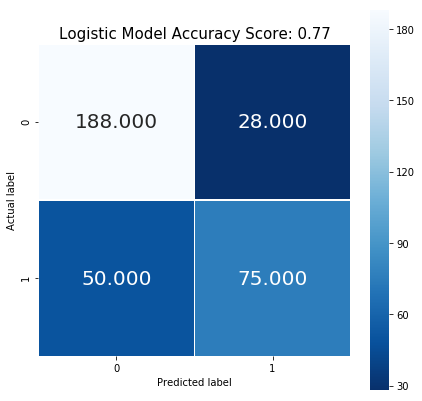

In [120]:
# Compute and visualize confusion matrix 
cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Model Accuracy Score: {:.2f}'.format(score)

plt.title(all_sample_title, size = 15)
plt.show()

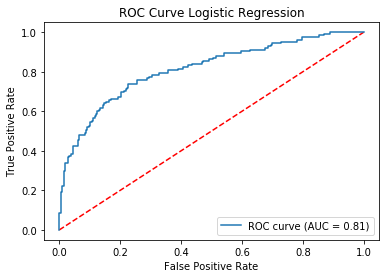

In [121]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Random Forest Model

In [122]:
# Instantiate
rf = RandomForestClassifier(n_estimators=10000)  

# Fit using scaled features
rf_model = rf.fit(X_train_std, y_train) 

# Predict the labels of the test set: y_pred
y_pred_rf = rf_model.predict(X_test_std)

# Use score method to get accuracy of model
score_rf = rf_model.score(X_test_std, y_test)

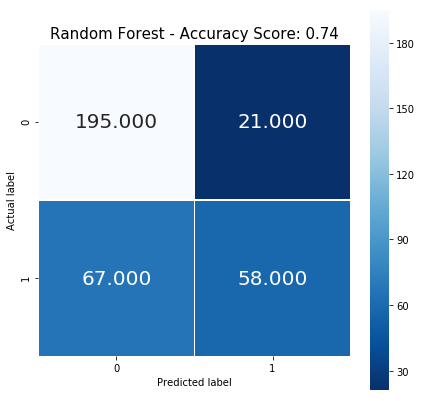

In [123]:
# Compute and visualize confusion matrix 
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7,7))
sns.heatmap(cm_rf, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest - Accuracy Score: {:.2f}'.format(score_rf)

plt.title(all_sample_title, size = 15)
plt.show()


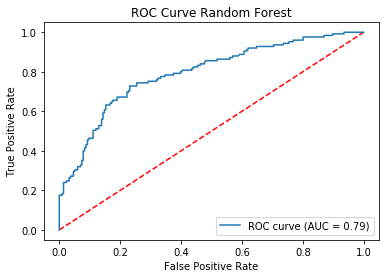

In [124]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_rf = rf_model.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)

auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')

plt.plot(fpr_rf, tpr_rf, label = 'ROC curve (AUC = %0.2f)' % auc_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend(loc='lower right')
plt.show()

<div class="span5 alert alert-info">
<p> Selecting 20 most important features. </p>
</div>

In [125]:
importances = rf_model.feature_importances_

# get column names of top 20 features in ascending order
indices = importances.argsort()[-20:][::-1].tolist()
top20 = X_train.columns[indices][::-1].tolist()

In [159]:
print(top20)

['P56', 'V140', 'P86', 'C16', 'P31', 'P8', 'V128', 'V127', 'V274C', 'P132', 'P55', 'V261', 'V145', 'V125', 'V123', 'V148', 'V135', 'V133', 'V139', 'V332']


In [126]:
column_names = ['Total Family Income', 'White Student Percentage', 'Relatives In County', 'Parent Education Level',
                'Self Esteem Scale', 'Desired Job Prestige score', 'Parent Arrival Year', 'Desired Job SEI score',
                'Friends Full-time Job Post-HS',"Parent's Education Expectation", 'Parent Monthly Earnings', 
                'Subsidized School Lunch Eligibility %', 'Respondent Educational Expectation', "Father Occupational Prestige",
                "Father's SEI score", 'Parent SES Index', 'Stanford Reading score', 'Stanford math score', 
                'Middle School GPA', 'High School GPA']

column_names = column_names[::-1]

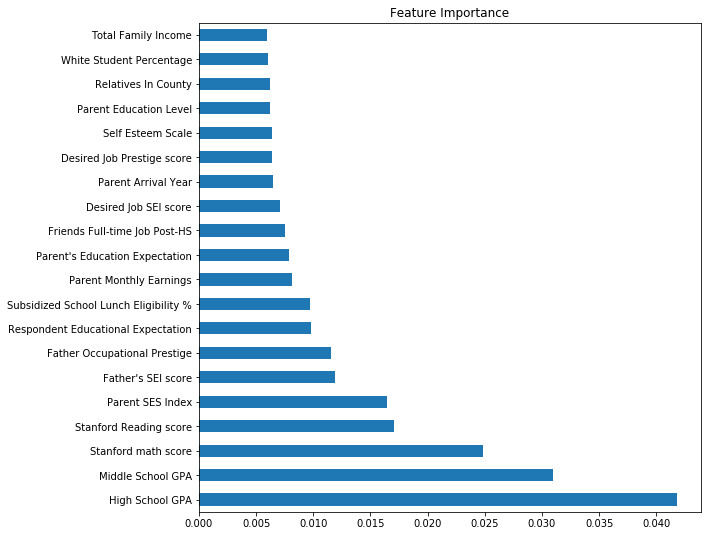

In [127]:
feat_importances = pd.Series(importances[indices], index= column_names)
feat_importances.plot(kind='barh', figsize = (9,9), title = "Feature Importance")